In [2]:
import so3g 
from spt3g import maps
from spt3g import core
from spt3g.core import G3Units as gu
from astropy.coordinates import EarthLocation, SkyCoord
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import g3_utils as ut

In [3]:
control_computer_g3_dir = pathlib.Path("/media/player1/blast2020fc1/blasttng_g3")
roach1_pass3_file = control_computer_g3_dir / "testing/roach1_pass3.g3"

ra_df_added = control_computer_g3_dir / "mapmaking/ra_df_added.g3"
norm_df_added = control_computer_g3_dir / "mapmaking/norm_df_added.g3"
source_ra_df_added = control_computer_g3_dir / "mapmaking/source_ra_df_added.g3"

In [4]:
def ang_to_quat_fixed(alpha, delta, start=None, stop=None):
    """
    Copied & fixed since maps.ang_to_quat has a missing return statement
    
    Convert a set of angles (or vector of them) specified as a (longitude,
    latitude) pair to a pointing quaternion (or vector of them). If start
    and stop are defined, the return value for vectors will be a
    G3TimestreamQuat with start and stop times set to the provided values.
    """

    alpha = np.asarray(alpha) / gu.rad
    delta = np.asarray(delta) / gu.rad
    # Copied from C code
    c_delta = np.cos(delta)
    q = np.column_stack(
        (
            0 * c_delta,  # 0s with the right shape
            c_delta * np.cos(alpha),
            c_delta * np.sin(alpha),
            np.sin(delta),
        )
    )

    if len(q) == 1:
        return core.quat(q[0, :])
    else:
        if start is not None:
            out = core.G3TimestreamQuat(q)
            out.start = start
            out.stop = stop
            return out
        else:
            return core.G3VectorQuat(q)

In [5]:
def radec_to_quats(frame, ra="ra", dec="dec", out_key="pointing"):
    if frame.type != core.G3FrameType.Scan:
        return
    quat_ts = ang_to_quat_fixed(
        frame[ra], frame[dec], start=frame[ra].start, stop=frame[ra].stop
    )
    ra1, dec1 = maps.quat_to_ang(quat_ts[0])
    print(ra1/gu.deg + 360, dec1/gu.deg)
    breakpoint()
    frame[out_key] = quat_ts

In [6]:
def superts_to_tsmap(frame, in_key="", out_key="", frame_type=None):
    frame_type = frame_type if frame_type is not None else core.G3FrameType.Scan
    if frame.type != frame_type:
        return
    super_ts = frame[in_key]
    frame[out_key] = core.G3TimestreamMap(super_ts.names, super_ts.data, super_ts.times[0], super_ts.times[-1])

In [28]:
# center of the sky map
# ra0 = 231.15 * core.G3Units.deg
# dec0 = -56.2 * core.G3Units.deg

xlen = 200
ylen = 200

# pixel resolution
res = 1 * core.G3Units.arcmin

smstub = maps.FlatSkyMap(
    xlen, ylen, res,
    proj=maps.MapProjection.ProjPlateCarree,
    alpha_center=0, delta_center=0,
    # x_center=0, y_center=0
)
print(smstub)

200 x 200 (3.333 x 3.333 deg) CAR centered at (99.5, 99.5) = (0, 0 deg) in equatorial coordinates (Tcmb, weighted)


In [32]:
map_frame_grabber = ut.NthFrameGrabber(1, core.G3FrameType.Map)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(source_ra_df_added))
pipe.Add(radec_to_quats, ra="ra_source", dec="dec_source")
pipe.Add(superts_to_tsmap, in_key="norm_df", out_key="norm_df_map")
pipe.Add(
    maps.HitsBinner,
    map_id="combined_map",
    stub_map=smstub,
    timestreams='norm_df_map',
    pointing='pointing',
)
pipe.Add(map_frame_grabber)
pipe.Add(ut.FrameCounter)
pipe.Run()

first_map_frame = map_frame_grabber.nth_frame
print("First map frame: ", first_map_frame)
print("FlatSkyMap: ", first_map_frame["T"])


Calibration
359.78729730808504 0.2958205341493811

360.2961669572608 0.18211968000259973
360.7590651243129 0.07067702717814593
360.5258318901651 0.1154736731161995
359.9300665502176 0.2368988066615495
359.95170859138864 0.2293948345518436
360.465075709109 0.10086485551944684
360.78923320528327 0.021846247017742824
360.23874100444044 0.13874443846208875
359.73322749306317 0.24481628654657314
360.1491031762462 0.14400592392096487
360.6175258885592 0.018862671156765008
360.59767002211106 0.007166335469401423
359.98987196592026 0.13925834926887462
359.78111720978393 0.19040163875009314
360.3166594802319 0.06996492586785769
360.75386543280416 -0.02863442419353333
360.3385407210975 0.06031197930681094
359.77563977427207 0.18619579671613637
359.9930542450875 0.12524820885105276
360.4943859460449 0.004141828752158994
360.6742592681971 -0.045930119796505776
360.0733130468981 0.08578742511512924
359.69553021501804 0.1766661228562262
360.2047642666865 0.055722686237828216
360.6750070305451 -0.05

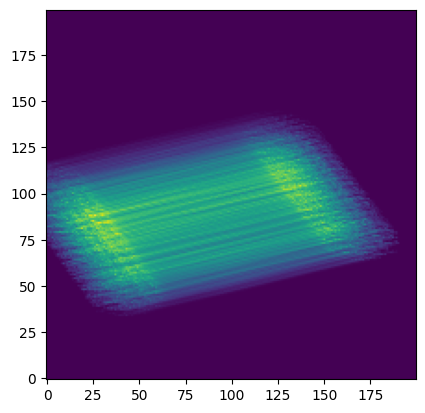

In [33]:
im = np.asarray(first_map_frame["H"])
plt.imshow(im, origin='lower')
plt.show()

In [75]:
max_indices = np.unravel_index(np.argmax(im), im.shape)
print(smstub.xy_to_angle(float(max_indices[0]), float(max_indices[1])) / gu.deg)
print(max_indices[1], max_indices[0])

spt3g.core.DoubleVector([324.5, -157.5])
22 215


In [88]:
print(smstub.angle_to_xy(ra0, dec0))
print(smstub.xy_to_angle(*smstub.angle_to_xy(ra0, dec0)) / gu.deg)

spt3g.core.DoubleVector([308.35, 123.3])
spt3g.core.DoubleVector([231.15, -56.2])
